# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

## `Задание 02. Сегментация изображений`

#### Фамилия, имя:

Дата выдачи: <span style="color:red">__3 марта 19:00__</span>.

Мягкий дедлайн: <span style="color:red">__17 марта 5:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4.25 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `U-Net` и `LinkNet`.

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Загрузка данных (1 балл)`

In [1]:
import os

import numpy as np
import numpy.testing as npt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с ImageNet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [6]:
from PIL import Image
import torchvision

class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one img.
            Corresponding mask and img have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.transforms = transforms

        self.image_filenames = [os.path.join(images_dir, fname) for fname in os.listdir(images_dir) if fname.endswith(('.jpg', '.png'))]
        self.masks_filenames = [os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(('.png'))]


    def __len__(self):
        return len(self.image_filenames)
        
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of img mask
        
        Returns
        -------
        (img, mask)
        """
        # img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        img_path = self.image_filenames[idx]    # выбираем одно изображение из списка image_filenames
        mask_path = self.masks_filenames[idx] 
        
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        # transform = torchvision.transforms.ToTensor()  # Преобразует (H, W, C) -> (C, H, W)
        if self.transforms is not None:
            img, mask = self.transforms(img, mask)
        else:
            transform = torchvision.transforms.ToTensor()  # Преобразует (H, W, C) -> (C, H, W)
            img = transform(img)
        return img, mask

## `Модуль аугментации (2 балла)`

Конструктор стандартного `ImageFolder`, принимает параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped img.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

1. случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения
2. случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
3. случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
4. случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

Используйте разумные пределы для аугментаций. Одной из причин плохого обучения модели могут быть слишком сильные аугментации. Визуально убедитесь, что граничные случаи достаточно адекватны задаче.

Обратите внимание, что под вырезанием фрагмента подрузумевается вырезания части изображения из исходного, то есть вырезание какой-то части изображения (создание отверстий в изображении). Если после слоя вырезания размеры изображения поменялись, то вы неправильно реализовали модуль.

In [7]:
import random


def random_apply(p):
    def decorator(transform):
        def func(*args, **kwargs):
            if random.random() < p:
                return transform(*args, **kwargs)
            return args[0], args[1]
        return func
    return decorator


def mask_apply(transform):
    def func(img, mask=None, *args, **kwargs):
        # нельзя просто писать (if mask), тк. mask - это тензор, который не может принимать булевого значения
        if mask is not None:
            return transform(img, mask, *args, **kwargs)
        return transform(img, *args, **kwargs)
    return func


In [12]:
# ! unzip people_data.zip

In [20]:
from PIL import ImageEnhance

p = 0.5

@random_apply(p)
@mask_apply
def horizontal_flip(img, mask):
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

    return img, mask


@random_apply(p)
def cutout(img, mask):
    w, h = img.size
    # можем вырезать от 0 до 50% картинки по вертикали и горизонтали
    min_h, max_h = 0, int(0.5 * h)
    min_w, max_w = 0, int(0.5 * w)

    # генерируем размер черной маски
    cut_w, cut_h = random.randint(a=min_w, b=max_w), random.randint(a=min_h, b=max_h)

    # генерируем случайные координаты верхнего левого угла прямоугольника, который будет вырезан
    x1, y1 = random.randint(0, w - cut_w), random.randint(0, h - cut_h)

    img = img.copy()
    img.paste(Image.new("RGB", (cut_w, cut_h), (0, 0, 0)), (x1, y1))

    return img, mask


@random_apply(p)
def brightness_change(img, mask, min_factor=0.3, max_factor=0.8):
    factor = random.uniform(a=min_factor, b=max_factor)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(factor)

    return img, mask


background_dir = "C:/Users/LenanXD/Desktop/MSU/3/DL/2/people_data/background"
background_images = [Image.open(os.path.join(background_dir, fname)) 
                     for fname in os.listdir(background_dir) 
                     if fname.endswith(('.jpg', '.png', '.jpeg'))]
@random_apply(p)
def background_change(img, mask, background_images=background_images):
    background = random.choice(background_images).resize(img.size)
    # Image.composite объединяет исходное изображение и выбранный фон в зависимости от маски
    # Маска преобразуется в оттенки серого с помощью convert("L"), где белые участки маски для ориг изображения, а черные — для фонв
    img = Image.composite(img, background, mask.convert("L")) if mask else img

    return img, mask


Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

In [14]:
import torchvision.transforms as transforms

class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        for t in self.transforms:
            if isinstance(t, (transforms.ToTensor, transforms.Normalize)):
                if isinstance(t, transforms.ToTensor):
                    img = t(img)
                    mask = t(mask)
                else:
                    img = t(img)
            else:
                img, mask = t(img, mask)
        return img, mask


transform = DualCompose([
    horizontal_flip,
    background_change,
    brightness_change,
    cutout,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# images_dir = "C:/Users/LenanXD/Desktop/MSU/3/DL/2/people_data/train"
# masks_dir = "C:/Users/LenanXD/Desktop/MSU/3/DL/2/people_data/train_mask"

# def numeric_sort(filename):
#     return int(filename.split('.')[0])

# image_files = sorted(os.listdir(images_dir), key=numeric_sort)
# mask_files = sorted(os.listdir(masks_dir), key=numeric_sort)

# # Создаем соответствие между изображениями и масками
# image_mask_pairs = [(os.path.join(images_dir, image), os.path.join(masks_dir, mask)) for image, mask in zip(image_files, mask_files)]


Image: /kaggle/input/people-dataset/train/1.jpg, Mask: /kaggle/input/people-dataset/train_mask/1.png
Image: /kaggle/input/people-dataset/train/2.jpg, Mask: /kaggle/input/people-dataset/train_mask/2.png
Image: /kaggle/input/people-dataset/train/3.jpg, Mask: /kaggle/input/people-dataset/train_mask/3.png
Image: /kaggle/input/people-dataset/train/4.jpg, Mask: /kaggle/input/people-dataset/train_mask/4.png
Image: /kaggle/input/people-dataset/train/5.jpg, Mask: /kaggle/input/people-dataset/train_mask/5.png


In [18]:
DATA_PATH = "C:/Users/LenanXD/Desktop/MSU/3/DL/2/people_data"

train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=transform
)

t0 = DualCompose([transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])
                ])

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test'),
    target_dir=os.path.join(DATA_PATH, 'test_mask'),
    transforms=t0
)

Функция для отображения изображения:

In [11]:
def show_idx_image(dataset, idx):
    
    img, mask = dataset[idx]

    img = img.permute(1, 2, 0).numpy()  # Меняем (C, H, W) -> (H, W, C)
    img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # Денормализация
    img = np.clip(img, 0, 1)  # Ограничиваем значения в диапазоне [0,1]

    mask = torch.tensor(np.array(mask)) 
    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(img)
    axes[1].imshow(mask)
    
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    
    fig.tight_layout()
    plt.show()

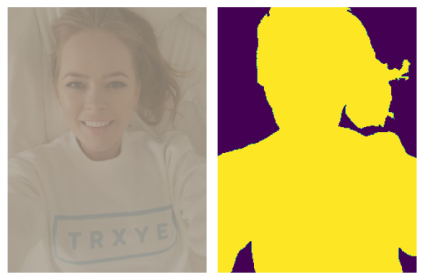

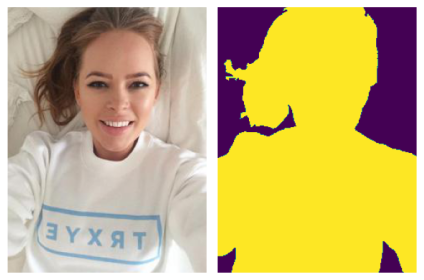

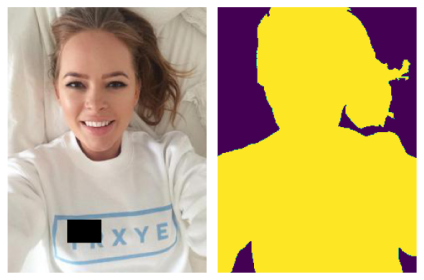

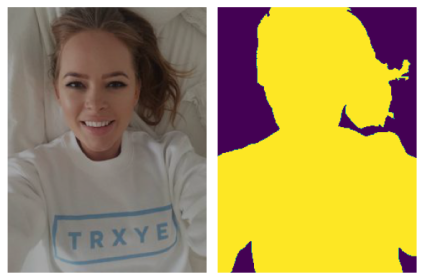

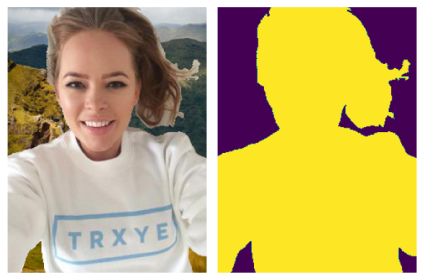

In [21]:
p = 1

train_dataset_None = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=None
)
show_idx_image(train_dataset_None, 0)

t1 = DualCompose([horizontal_flip,
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])
                ])
train_dataset_horizontal_flip = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=t1
)
show_idx_image(train_dataset_horizontal_flip, 0)

t2 = DualCompose([cutout,
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])
                ])
train_dataset_cutout = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=t2
)
show_idx_image(train_dataset_cutout, 0)

t3 = DualCompose([brightness_change,
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])
                ])
train_dataset_brightness_change = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=t3
)
show_idx_image(train_dataset_brightness_change, 0)

t4 = DualCompose([background_change,
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])
                ])
train_dataset_background_change = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=t4
)
show_idx_image(train_dataset_background_change, 0)

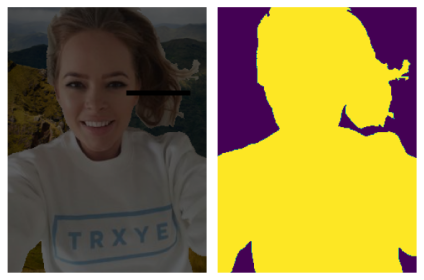

In [19]:
p = 0.5
show_idx_image(train_dataset, 0)

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных. Необходимо проверить каждый модуль аугментации отдельно, в ином случае будут сниматься баллы.

**Важно:** Проверьте корректность работы модулей, действительно ли маска изображения корректна для изображения после аугментации.

## `Загрузчики`

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и так далее) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

Обычно, скорость обработки данных на GPU превышает скорость загрузки данных в одном процессе, поэтому типичное значение для `num_workers`$\approx 3\text{-}10$.

Учтите, что на некоторых системах в Jupyter Notebook при `num_workers`$>0$ `DataLoader` перестаёт работать. В таком случае установите это значение в $0$.

In [20]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=0)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True)

## `DiceLoss (1 балл)`

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через `torch.nn.Module`. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат **Dice Loss** определим как:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — истинная разметка для пикселя изображения.

In [22]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:

            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed.
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits

    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.long)

        if self.with_logits:
            logits = torch.sigmoid(logits)

        logits_flat = logits.view(logits.size(0), -1)
        true_labels_flat = true_labels.view(true_labels.size(0), -1)

        intersection = (logits_flat * true_labels_flat).sum(dim=1)
        union = (logits_flat + true_labels_flat).sum(dim=1)

        dice_coefficient = (2 * intersection + self.eps) / (union + self.eps)

        dice_loss = 1 - dice_coefficient

        if self.reduction == 'sum':
            loss_value = dice_loss.sum()
        elif self.reduction == 'mean':
            loss_value = dice_loss.mean()
        elif self.reduction is None:
            loss_value = dice_loss

        return loss_value

Проверка реализации:

In [23]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net (3 балла)`

Для решения задачи сегментации будем использовать [U-Net](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`.

Концептуальная схема представлена на диаграмме ниже:

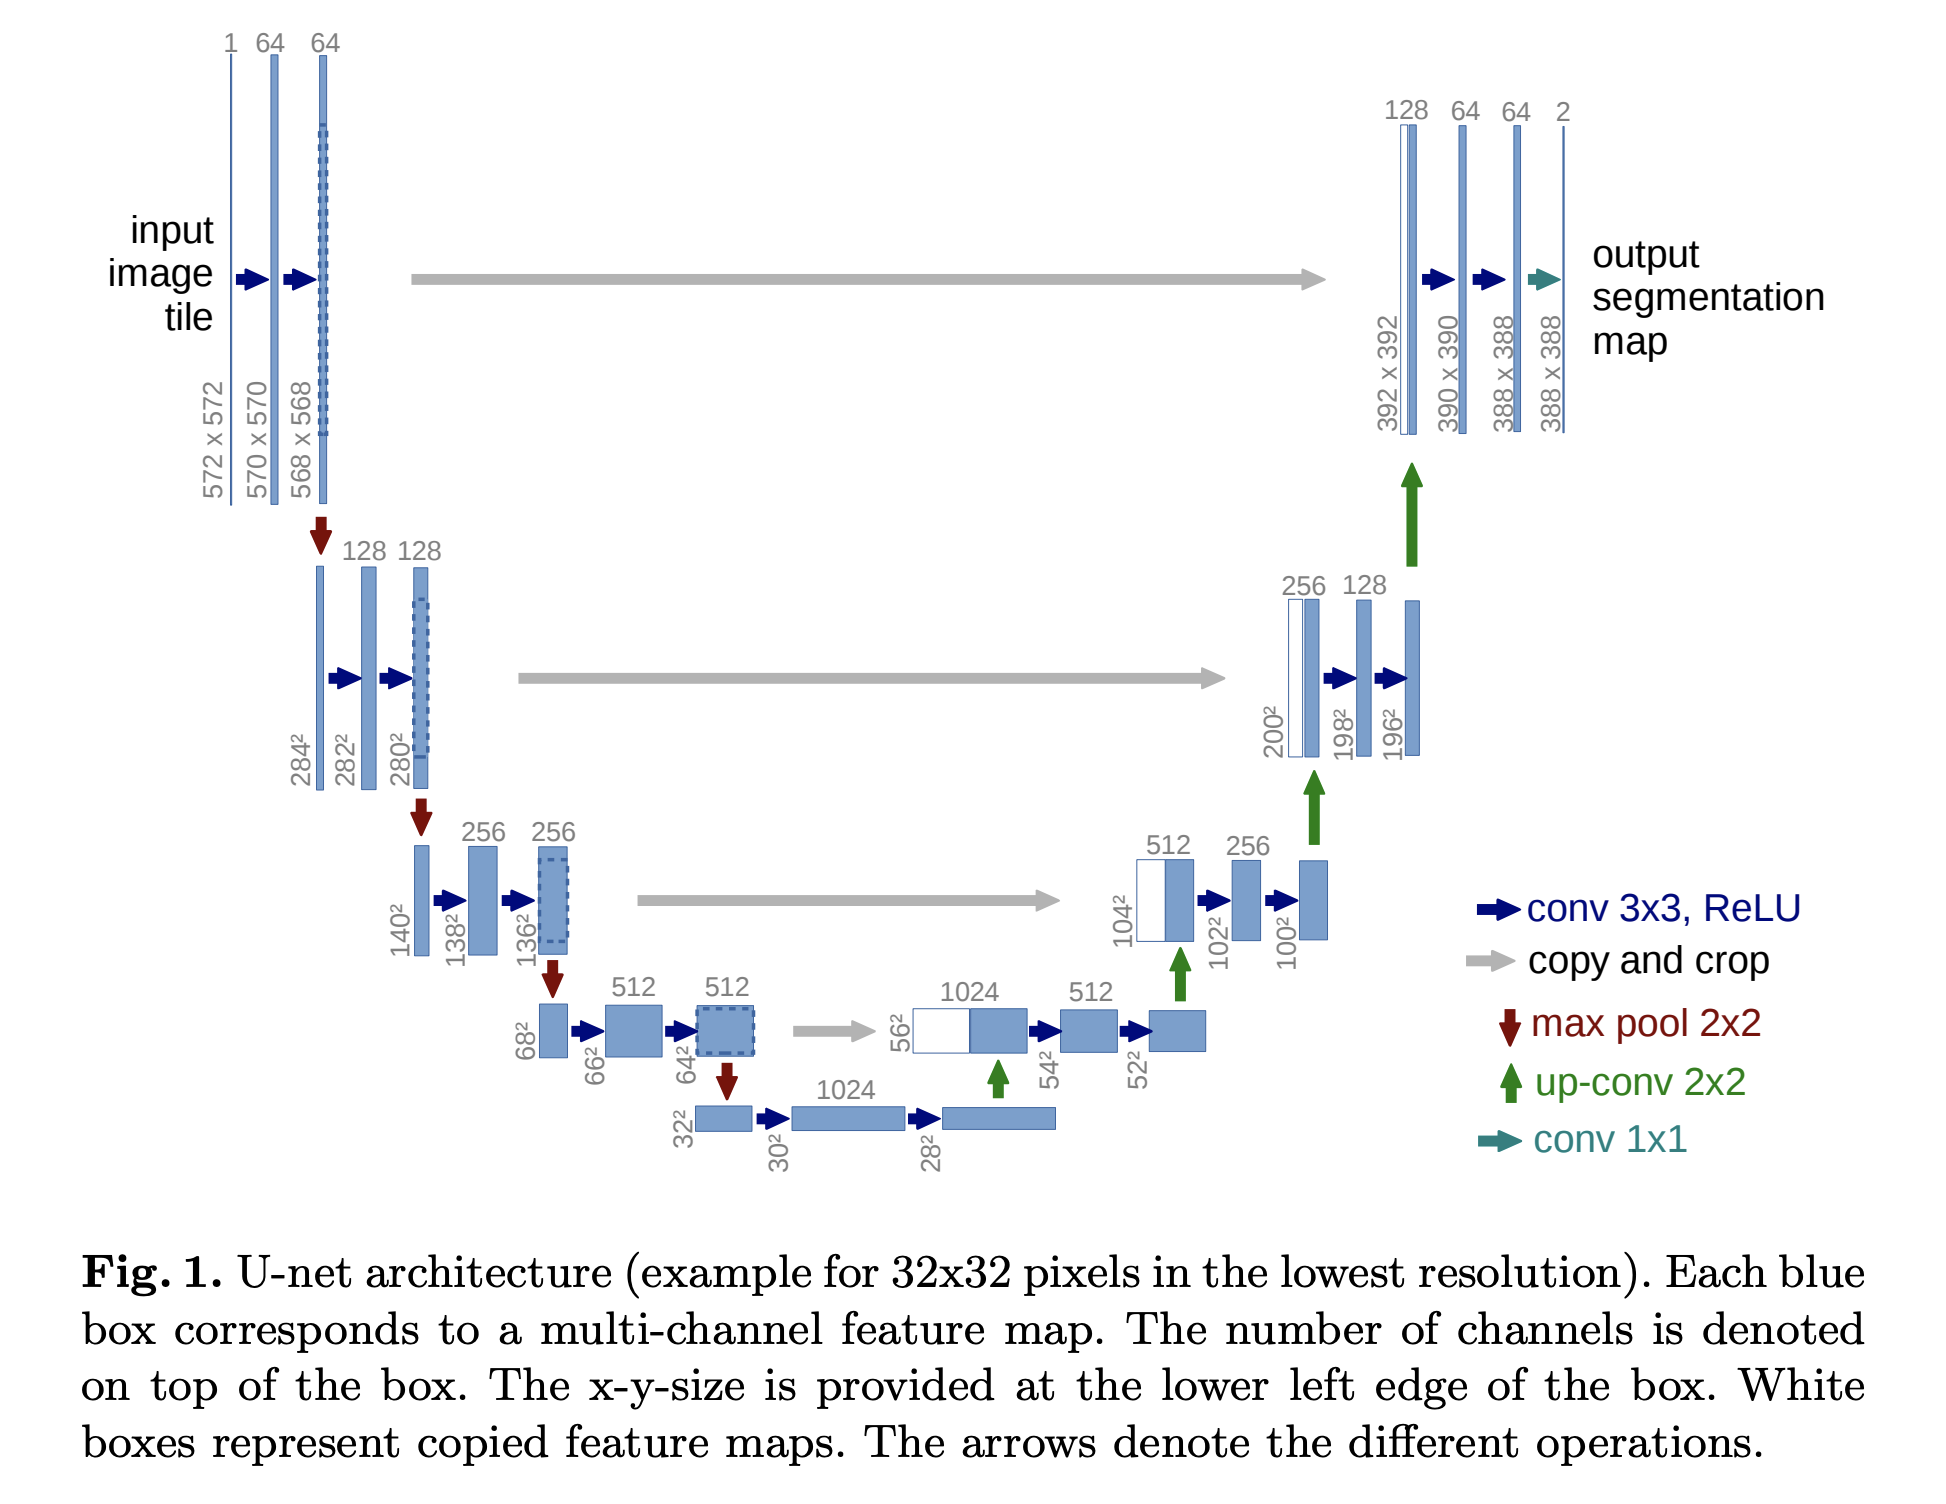

Заметим, что блоки VGG13 имеют следующий вид:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

Для удобства, уберём слои `MaxPool2d` из блоков энкодера и будем применять pooling отдельно. Возможно, вам будет полезно вывести архитектуру модели `VGG` и изучить параметры слоев pooling.

При реализации `Decoder` вам пригодится интерполяция, для этого можно использовать `torch.nn.functional.interpolate` с `mode=nearest`.

Реализуйте архитектуру данной сети.

#### `Encoder`

In [24]:
from torch.functional import F


class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks

        # Будем использовать предобученную VGG13 в качестве backbone
        feature_extractor = vgg13(weights=weights).features

        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList()

        start_idx = 0
        for idx in range(self.num_blocks):
            end_idx = start_idx
            # Возьмите нужные слои из `feature_extractor` для очередного U-Net блока
            # Объедините их с помощью `torch.nn.Sequential`
            while not isinstance(feature_extractor[end_idx], torch.nn.MaxPool2d):
                end_idx += 1
            self.blocks.append(torch.nn.Sequential(*feature_extractor[start_idx:end_idx]))
            # пропускаем MaxPool
            start_idx = end_idx + 1


    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # Примените очередной блок U-Net
            x = block(x)

            # Сохраните активации для передачи их в декодер
            activations.append(x)

            # При необходимости примените max-pool
            # Можно использовать `torch.functional.F.max_pool2d`
            if idx < self.num_blocks - 1:  # Не пулим последний выход
                x = F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

In [25]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

#### `Decoder`

In [26]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()

    def forward(self, down, left):
        # Upsample x2 и свёртка
        x = F.interpolate(down, scale_factor=2, mode="nearest")
        x = self.upconv(x)

        # Конкатенация выхода энкодера и предыдущего блока декодера
        x = torch.cat([x, left], dim=1)

        # Две свёртки с ReLu
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        return x

In [27]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(out_channels=num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

#### `U-Net`

In [28]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=3):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks-1)

        # Свёртка 1x1 для попиксельной агрегации каналов
        self.final = torch.nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        activations = self.encoder.forward(x)
        x = self.decoder.forward(activations)
        x = self.final(x)
        return x

In [29]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
        (upconv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       


### `Оценивание качества сети`


Обычно, оптимизируемый функционал сложно интерпретировать, а так же в разных экспериментах могут использоваться разные функции потерь. Поэтому необходимо замерять и отслеживать независимую метрику качества. Предлагается использовать **IoU (Intersection over Union)** — один из стандартных вариантов для задачи сегментации:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

Учтите, что знаменатель может быть равен нулю, например, если маска нулевая. Такие объекты можно не учитывать при агрегации и пропускать, так как в ином случае подсчет метрики на всем батче будет NaN. В pytorch есть встроенные для этого функции с префиксом nan.


In [31]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:

            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed.
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()

        self.threshold = threshold
        self.reduction = reduction

    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        preds = (logits > self.threshold).float()

        intersection = torch.sum(preds * true_labels, dim=(1,2))
        union = torch.sum(preds, dim=(1,2)) + torch.sum(true_labels, dim=(1,2)) - intersection

        # заменяем NaN на 0.0
        iou = torch.nan_to_num(intersection / union, nan=0.0)

        if self.reduction == 'mean':
            return iou.mean()
        elif self.reduction == 'sum':
            return iou.sum()
        return iou  # [B]

In [32]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

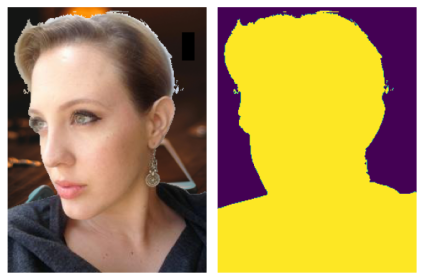

In [42]:
show_idx_image(train_dataset, 2)

### `Логирование`

При реализации цикла обучения необходимо сохранять метрики $1\text{-}9$ с использованием модуля [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html) или с помощью модуля [wandb](https://docs.wandb.ai/tutorials/) вам предлагается самим выбрать более удобный для вас модуль.

Для отслеживания процесса обучения обычно требуется сохранять информацию разных его аспектах.

Для полного контроля над процессом обучения обычно требуется сохранять информацию о разных статистиках. Самыми очевидными являются:
1. Значение функции потерь (лосса) на обучающей и тестовой выборках
2. Метики качества, например, **Dice Coefficient** и **IoU (Intersection over Union)** на обучающей и тестовой выборках

Однако, суррогатные метрики могут не отражать реального качества. Поэтому для моделей, которые выдают визуализируемый результат, обычно логируют предсказания для некоторых объектов выборки. В задаче сегментации естественным вариантом является логирование четвёрки: исходное изображение, истинная маска, маска вероятностей истинного класса, бинаризованная маска.

*Замечание:* лосс и качество на обучающей выборке обычно логируют не только в конце каждой эпохи, но и по отдельным батчам на каждой итерации.

3. Чтобы отслеживать динамику обучения необходимо зафиксировать небольшой набор объектов обучающей и тестовой выборок и после каждой эпохи обучения логировать указанные четыре картинки для каждого объекта.

*Замечание:* можно логировать четвёрки изображений независимо, однако, удобнее объединить их на одной фигуре [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure), [реализация через Wandb](https://docs.wandb.ai/guides/track/log/plots/#matplotlib-and-plotly-plots) (лучше делать через fig и Image). Дополнительный плюс — возможность подписать значения метрик для этого объекта в заголовке изображения или добавить colorbar для более простой интерпретации предсказанной маски.

Для удобной категоризации экспериментов обычно в начале обучения сохраняют:

4. Гиперпараметры модели [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams), [реализация через Wandb](https://docs.wandb.ai/guides/track/config/)
5. Структуру модели [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph), **про реализацию wandb ниже**

Для исследования технических особенностей обучения полезно логировать следующие статистики:

6. Распределение весов, активаций, градиентов [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram), [реализация через Wandb](https://docs.wandb.ai/ref/python/data-types/histogram/). Сохранять гистограммы каждого параметра после каждой итерации может быть вычислительно неэффективно, поэтому обычно сохраняют распределения весов для каждого отдельного слоя нейронной сети после каждой эпохи.
7. Норма весов и норма градиента на каждой итерации

Наконец, после каждой эпохи можно визуализировать промежуточные представления входных данных:

8. Активации после каждого слоя/блока, как изображения
9. Градиенты функции потерь по активациям для некоторых объектов обучающей выборки, как изображения

*Замечание:* для реализации пунктов 8, 9 менять код модели не требуется. Используйте хуки: [register_full_backward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook) (данный хук не работает с inplace операциями, например, с `torch.nn.ReLU(inplace=True)`. Или не используйте inplace операции, или используйте [`Tensor.register_hook`](https://github.com/pytorch/pytorch/issues/61519)), [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook).

Файлы с логами, а также чекпоинты весов модели после итерации с наилучшим валидационным качеством (смотрите [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html) и [torch.nn.Module.state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) для **ВСЕХ** проведённых экспериментов (за исключением упавших, недосчитанных и так далее) необходимо сдать в anytask.

#### `Некоторые советы по wandb`

- При логировании всегда указывайте параметр step, который должен не уменьшаться.

- При логировании изображений лучше их нормировать в диапазон [0, 1] как в функции `show_idx_image` выше. Для логирования предсказаний маски, лучше использовать вероятности. При неправильном диапозоне изображения могут отображаться неверно!

- Вместо логирования изображений, лучше логировать `matplotlib` графики и соответсвующие им `figure`. Кроме того, лучше закрывать все открытые графики, чтобы не перегружать ноутбук. Пример кода:


```python
fig, ax = plt.subplots(...)
...
wandb.log({key: wandb.Image(fig)}, step=global_step)
plt.close('all')
```

- Функционал построение bins в `wandb.Histogram` ограничен, можете посмотреть в сторону аргумента `np_histogram`.

- Wandb не имеет широкого функционала для логирования структуры модели. Есть способ через wandb.watch(net, log_graph=True), но получаемый результаты сильно отличаются от возможностей `tensorboard`. К счастью, `wandb` умеет синхронизировать логи с `Tensorboard` поэтому можно использовать следующую логику:


```python
wandb.init(
    project=project_name,
    name=run_name,
    config=config,
    sync_tensorboard=True        # Синхронизация с tensorboard
)

writer = SummaryWriter(run_name) # Создание логера tensorboard

# Логирование графа модели
writer.add_graph(net, input_x)
writer.close()

train_loop(...)
wandb.finish()
```

- `wandb` по умолчанию сохраняет все логи локально и на сайте в вашем личном хранилище. В случае перезагрузки `Google Colab` локальные файлы не сохраняются! Кроме того, скачивание файлов не через GoogleDisk достаточно продолжительное (в районе 20-30 минут).

- В `wandb` можно легко сохранять код и указать директорию, так вы никогда не забудете какой именно код получает результаты логов.

```python
wandb.init(..., settings=wandb.Settings(code_dir="."))
```

Кроме того, можно сохранить отдельные файлы:

```python
wandb.init(..., save_code=True)
wandb.run.log_code(
    "./",
    include_fn=lambda path: condition(path)
)
```

- В `wandb` есть функция для автоматического логирования весов и градиентов модели `wandb.watch()`, но функционал слишком ограничен и накладывает слишком много накладных расходов. **Лучше писать руками!**

#### `Некоторые советы по tensorboard`

- Функционал и возможности `tensorboard` шире (работа с 3D, продвинутые визуализации).

- `tensorboard` сохраняет логи только локально, то есть после закрытия `Google Colab` ничего не сохранится. В реальных проектах это является сильной стороной, так как гарантирует безопасность и конфиденциальность.

- Для визуализации логов достаточно запустить в ноутбуке или в терминале соответсвующее расширение, однако в случае `Google Colab` для этого приходится прокидывать порты, [подробнее тут](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).

- `tensorboard` меньше лагает и более легковесный.


### `Некоторые советы по логированию`

- Вы можете выбрать либо `wandb`, либо `tensorboard`.

- В реальных проектах лучше добавить логирование кода с целью сохранения и воспроизводимости результатов.

- Называйте запуски осмысленно, чтобы по названию можно было понять смысл запуска и варьеруемые параметры.


In [6]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_api = user_secrets.get_secret("wandb_api") 

wandb.login(key=wandb_api)

wandb: Currently logged in as: keiiino (keiiino_). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
import random
import numpy as np
import torch

def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_global_seed(42)

In [59]:
import wandb

config = {
    "lr": 0.001,                 # Learning rate
    "epochs": 5,                # Количество эпох
    "batch_size": 8,             # Размер батча
    "loss_type": "dice",     # Тип функции потерь: 'BCE', 'dice' или 'combined'
    "bce_weight": 0.5,           # Важность BCE потери в комбинированной потере
    "dice_weight": 0.5,          # Важность Dice потери в комбинированной потере
}

# wandb.init(project="DL_dz3_segmentation", name="bce", config=config)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Модель и оптимизатор
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
bce_loss = torch.nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

activations, gradients = {}, {}

In [33]:
def save_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

def save_gradient(name):
  def hook(model, grad_input, grad_output):
      gradients[name] = grad_output[0].detach()
  return hook

# Регистрируем хуки для каждого слоя
def register_hooks(model):
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Conv2d):
            layer.register_forward_hook(save_activation(name))
            layer.register_full_backward_hook(save_gradient(name))

#Логирование графа модели
wandb.watch(model, log=None, log_graph=True)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
# Логируем активации
def log_activations(activations, epoch):
    for name, activation in activations.items():
        if len(activation.shape) == 4:
            fig, axes = plt.subplots(4, 4, figsize=(10, 10))
            fig.suptitle(f"Activations for {name}")
            for i, ax in enumerate(axes.flat):
                if i < activation.shape[1]:
                    ax.imshow(activation[0, i].cpu().numpy(), cmap='viridis')
                ax.axis('off')
            plt.tight_layout()

            wandb.log({f"Activations/{name}": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

# Логируем градиенты
def log_gradients(gradients, epoch):
    for name, gradient in gradients.items():
        if len(gradient.shape) == 4:
            fig, axes = plt.subplots(4, 4, figsize=(10, 10))
            fig.suptitle(f"Gradients for {name}")
            for i, ax in enumerate(axes.flat):
                if i < gradient.shape[1]:
                    ax.imshow(gradient[0, i].cpu().numpy(), cmap='viridis')
                ax.axis('off')
            plt.tight_layout()

            wandb.log({f"Gradients/{name}": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

# Логирование значений функции потерь и метрик
def log_epoch_metrics(train_loss, val_loss, train_iou, val_iou, global_step):
    wandb.log({
        "train_loss/epoch": train_loss,
        "val_loss/epoch": val_loss,
        "train_iou/epoch": train_iou,
        "val_iou/epoch": val_iou
    }, step=global_step)

# Логирование изображений сегментации
def log_segmentation_images(epoch, img, true_masks, pred_masks):
    images = []
    for i in range(min(len(img), 3)):
        fig, axs = plt.subplots(1, 4, figsize=(6, 3))

        image_tensor = img[i][0]
        image_np = image_tensor.cpu().numpy().transpose(1, 2, 0)

        # Денормализуем
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)

        axs[0].imshow(image_np)
        axs[0].set_title('Input Image')
        axs[0].set_axis_off()
        true_mask_tensor = true_masks[i][0]
        true_mask_np = true_mask_tensor.cpu().numpy().squeeze()

        axs[1].imshow(true_mask_np, cmap='gray')
        axs[1].set_title('True Mask')
        axs[1].set_axis_off()
        pred_mask_tensor = pred_masks[i][0]
        pred_mask_np = pred_mask_tensor.detach().cpu().numpy().squeeze()

        axs[2].imshow(pred_mask_np, cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].set_axis_off()
        binary_mask_np = (pred_mask_tensor > 0.5).cpu().numpy().squeeze()

        axs[3].imshow(binary_mask_np, cmap='gray')
        axs[3].set_title('Binary Mask')
        axs[3].set_axis_off()

        plt.tight_layout()
        images.append(wandb.Image(fig, caption=f"Epoch {epoch}, Sample {i}"))
        plt.show()
        plt.close(fig)


    wandb.log({"Segmentation Results": images})

In [ ]:
# Логируем результаты на тренировочной выборке
def train_epoch(model, train_data_loader, train_step, loss_type, epoch, bce_weight, dice_weight):
    model.train()
    total_loss = 0
    total_iou = 0
    num_batches = len(train_data_loader)

    for images, masks in train_data_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss_bce = bce_loss(outputs, masks.float())
        loss_dice = dice_loss(outputs, masks.float())

        if loss_type == "bce":
            loss = loss_bce
        elif loss_type == "dice":
            loss = loss_dice
        else:
            loss = bce_weight * loss_bce + dice_weight * loss_dice

        loss.backward()
        optimizer.step()

        iou = IoUScore(threshold=0.5, reduction="mean")(outputs, masks)
        total_loss += loss.item()
        total_iou += iou.item()

        wandb.log({"train/loss": loss.item(), "train/iou": iou.item()}, step=train_step)

        train_step += 1

    return total_loss / num_batches, total_iou / num_batches, train_step

# Логируем результаты на валидационной выборке
@torch.no_grad()
def validate_epoch(model, test_data_loader, loss_type, bce_weight, dice_weight):
    model.eval()
    total_loss = 0
    total_iou = 0
    num_batches = len(test_data_loader)
    all_images = []
    all_true_masks = []
    all_pred_masks = []

    k = 0

    for images, masks in test_data_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss_bce = bce_loss(outputs, masks.float())
        loss_dice = dice_loss(outputs, masks.float())

        if loss_type == "bce":
            loss = loss_bce
        elif loss_type == "dice":
            loss = loss_dice
        else:
            loss = bce_weight * loss_bce + dice_weight * loss_dice

        iou = IoUScore(threshold=0.5, reduction="mean")(outputs, masks)
        total_loss += loss.item()
        total_iou += iou.item()

        if k <= 2:
        # Сохраняем изображения и маски для логирования
          all_images.append(images)
          all_true_masks.append(masks)
          all_pred_masks.append(outputs)

        wandb.log({"val/loss": loss.item(), "val/iou": iou.item()})

        k += 1
        return all_images, all_true_masks, all_pred_masks, total_loss / num_batches, total_iou / num_batches


-----training done. start testing-----
Epoch 1: Train Loss: 0.5443, Val Loss: 0.0260, Train IoU: 0.5031, Val IoU: 0.0297


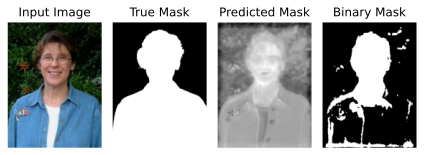

wandb: WARNING Tried to log to step 1 that is less than the current step 170. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 170 that is less than the current step 171. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


-----training done. start testing-----
Epoch 2: Train Loss: 0.3756, Val Loss: 0.0198, Train IoU: 0.6613, Val IoU: 0.0398


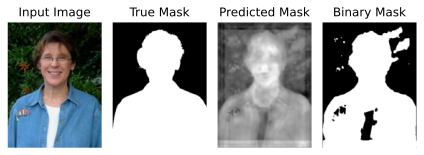

wandb: WARNING Tried to log to step 2 that is less than the current step 339. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 339 that is less than the current step 340. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


-----training done. start testing-----
Epoch 3: Train Loss: 0.3261, Val Loss: 0.0186, Train IoU: 0.6941, Val IoU: 0.0408


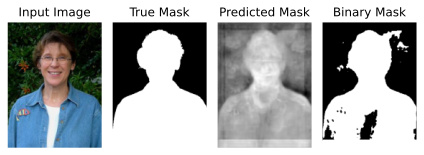

wandb: WARNING Tried to log to step 3 that is less than the current step 508. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 508 that is less than the current step 509. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


-----training done. start testing-----
Epoch 4: Train Loss: 0.2786, Val Loss: 0.0179, Train IoU: 0.7278, Val IoU: 0.0414


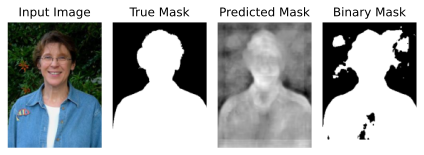

wandb: WARNING Tried to log to step 4 that is less than the current step 677. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 677 that is less than the current step 678. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


-----training done. start testing-----
Epoch 5: Train Loss: 0.2514, Val Loss: 0.0178, Train IoU: 0.7449, Val IoU: 0.0396


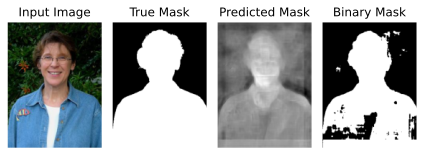

In [ ]:
%time
def train_test(epochs, train_data_loader, test_data_loader):
  train_step = val_step = 1
  for epoch in range(1, epochs + 1):
      train_loss, train_iou, train_step = train_epoch(train_data_loader, train_step, loss_type="bce", epoch=epoch, bce_weight=1.0, dice_weight=0.0)
      print("-----training done. start testing-----")
      images, true_masks, pred_masks, val_loss, val_iou = validate_epoch(test_data_loader, loss_type="bce", bce_weight, dice_weight, bce_weight=1.0, dice_weight=0.0)

      print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}")
      # Логируем градиенты
      log_gradients(gradients, epoch)
      # Логируем активации
      log_activations(activations, epoch)
      # Логируем метрики
      log_epoch_metrics(train_loss, val_loss, train_iou, val_iou, epoch)
      # Логируем сегментации
      log_segmentation_images(epoch, images, true_masks, pred_masks)


  wandb.save("best_model.pth")
  wandb.log({"hparams": config})
  wandb.finish()

train_test(config["epochs"], train_data_loader, test_data_loader)


In [62]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### `Эксперименты`

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке.

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации:
1. Только кросс-энтропия
2. Только dice loss
3. Сумма двух лоссов с весами (попробуйте $3\text{-} 4$ разных соотношения)

**Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
bce_loss = torch.nn.BCELoss()

# Функция для обучения и логирования
def train_and_evaluate(model, loss_type, bce_weight=1.0, dice_weight=1.0):
    train_losses, val_losses = [], []
    train_ious, val_ious = [], []
    
    train_step, val_step = 0, 0

    if loss_type == "bce":
        bce_weight = 1.0
        dice_weight = 0.0
    elif loss_type == "dice":
        bce_weight = 0.0
        dice_weight = 1.0

    for epoch in range(1, config["epochs"] + 1):
        train_loss, train_iou, train_step = train_epoch(model, train_data_loader, train_step, loss_type=loss_type, epoch=epoch, bce_weight=bce_weight, dice_weight=dice_weight)
        images, true_masks, pred_masks, val_loss, val_iou = validate_epoch(model, test_data_loader, loss_type=loss_type, bce_weight=1.0, dice_weight=0.0)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ious.append(train_iou)
        val_ious.append(val_iou)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}")

    return train_losses, val_losses, train_ious, val_ious, images, true_masks, pred_masks

# Запуск обучения для разных стратегий
wandb.init(project="DL_dz3_segmentation", name="experiment_bce", config=config)
print("Training with BCE Loss")
bce_results = train_and_evaluate(model, loss_type="bce")


Training with BCE Loss


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:

wandb.init(project="DL_dz3_segmentation", name="experiment_dice", config=config)
print("Training with Dice Loss")
dice_results = train_and_evaluate(model, loss_type="dice")

wandb.init(project="DL_dz3_segmentation", name="experiment_50%bce/50%dice", config=config)
print("Training with 50% BCE + 50% Dice")
combined_results_50_50 = train_and_evaluate(model, loss_type="combined", bce_weight=0.5, dice_weight=0.5)

wandb.init(project="DL_dz3_segmentation", name="experiment_75%bce/25%dice", config=config)
print("Training with 75% BCE + 25% Dice")
combined_results_75_25 = train_and_evaluate(model, loss_type="combined", bce_weight=0.75, dice_weight=0.25)

wandb.init(project="DL_dz3_segmentation", name="experiment_25%bce/75%dice", config=config)
print("Training with 25% BCE + 75% Dice")
combined_results_25_75 = train_and_evaluate(model, loss_type="combined", bce_weight=0.25, dice_weight=0.75)



In [ ]:
# Функция для отображения графиков
def plot_results(results, title):
    train_losses, val_losses, train_ious, val_ious, _, _, _ = results
    epochs = range(1, config["epochs"] + 1)

    plt.figure(figsize=(12, 5))

    # График функции потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    # График  IoU
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_ious, label="Train IoU")
    plt.plot(epochs, val_ious, label="Validation IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU Score")
    plt.title(f"{title} - IoU Score")
    plt.legend()

    plt.show()

# Отображение графиков
plot_results(bce_results, "BCE Loss")
plot_results(dice_results, "Dice Loss")
plot_results(combined_results_50_50, "50% BCE + 50% Dice")
plot_results(combined_results_75_25, "75% BCE + 25% Dice")
plot_results(combined_results_25_75, "25% BCE + 75% Dice")

# Функция для отображения предсказанных масок
def show_pred_masks(results, title):
    images, true_masks, pred_masks = results[4], results[5], results[6]

    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(3):
        axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0))
        axes[i, 0].set_title("Original Image")

        axes[i, 1].imshow(true_masks[i].cpu().squeeze(), cmap="gray")
        axes[i, 1].set_title("True Mask")

        axes[i, 2].imshow(torch.sigmoid(pred_masks[i].cpu()).squeeze().detach().numpy(), cmap="gray")
        axes[i, 2].set_title("Predicted Mask")

    plt.suptitle(title)
    plt.show()

# Отображение предсказанных масок
show_pred_masks(bce_results, "BCE Loss Predictions")
show_pred_masks(dice_results, "Dice Loss Predictions")
show_pred_masks(combined_results_50_50, "50% BCE + 50% Dice Predictions")
show_pred_masks(combined_results_75_25, "75% BCE + 25% Dice Predictions")
show_pred_masks(combined_results_25_75, "25% BCE + 75% Dice Predictions")


## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections (сложения). Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

*Подсказка:* так как конкатенации слоёв заменили на skip-connections, то ожидается, что число параметров стало меньше.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

In [ ]:
class LinkNetDecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()

    def forward(self, down, left):
        x = F.interpolate(down, scale_factor=2, mode="nearest")
        x = self.upconv(x)

        # Skip connection через сложение
        x = x + left

        x = self.relu(self.conv1(x))
        return x

class LinkNetDecoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()
        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, LinkNetDecoderBlock(out_channels=num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=3):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = LinkNetDecoder(num_filters=64, num_blocks=num_blocks - 1)

        self.final = torch.nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        activations = self.encoder.forward(x)
        x = self.decoder.forward(activations)
        x = self.final(x)
        return x

In [ ]:
model = LinkNet().to(device)

# Запуск обучения для разных стратегий
print("Training with BCE Loss")
bce_results = train_and_evaluate(model, loss_type="bce")

print("Training with Dice Loss")
dice_results = train_and_evaluate(model, loss_type="dice")

print("Training with 50% BCE + 50% Dice")
combined_results_50_50 = train_and_evaluate(model, loss_type="combined", bce_weight=0.5, dice_weight=0.5)

print("Training with 75% BCE + 25% Dice")
combined_results_75_25 = train_and_evaluate(model, loss_type="combined", bce_weight=0.75, dice_weight=0.25)

print("Training with 25% BCE + 75% Dice")
combined_results_25_75 = train_and_evaluate(model, loss_type="combined", bce_weight=0.25, dice_weight=0.75)

# Отображение графиков
plot_results(bce_results, "BCE Loss")
plot_results(dice_results, "Dice Loss")
plot_results(combined_results_50_50, "50% BCE + 50% Dice")
plot_results(combined_results_75_25, "75% BCE + 25% Dice")
plot_results(combined_results_25_75, "25% BCE + 75% Dice")

# Отображение предсказанных масок
show_pred_masks(bce_results, "BCE Loss Predictions")
show_pred_masks(dice_results, "Dice Loss Predictions")
show_pred_masks(combined_results_50_50, "50% BCE + 50% Dice Predictions")
show_pred_masks(combined_results_75_25, "75% BCE + 25% Dice Predictions")
show_pred_masks(combined_results_25_75, "25% BCE + 75% Dice Predictions")

## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей.
* Какие преимущества дает использование сверток в случае, если эти предположения верные?
* Приведите пример входных данных, когда эти предположения не выполняются.

*Ваш ответ в этой ячейке*
#### Предположения о структуре входных данных
* Данные, на которые опирается структура свертовных сетей, должны иметь взаимосвязь между близлежащими пикселями и иметь локальную структуру. Например: углы, границы и т.д
* Это предполагает инвариантность каких-то локальных частей относительно места на изображении. Например, кот может находится на картинке в центре, а может в углу, и сверточные нейросети должы уметь распознать кота и в первом случае, и во втором, так как по сути признак остается прежним.

#### Преимущества сверток
* Отпадает необходимость в полносвязных сетях, так как теперь нет нужны учитывать связь отдельного нейрона со всеми остальными - достаточно его связи с ближлежащими. Это может разрядить сеть и уменьшить число параметров.
* Следует напрямую из 2 пункта предположений: позволяет выявлять объекты внезависимости от их местоположения.
* Выявление сложных признаков - с каждым новым слоем выявляются всё более сложные структуры: сначала границы, затем формы, затем сложные объекты.

#### Пример входных данных, когда эти предположения не выполняются
* Самым очевидным является текст - хотя слова и имеют корелляцию в пределах предложения, существуют долгосрочные зависимости (например, какое-то предложение может отсылаться на начало, спустя большой промежуток текста), которые такие сети будут очень плохо улавливать.
* Такими же свойствами обладают финансовые ряды

### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$.

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации.

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите:

1. Размерность выходного пространства.
2. Количество обучаемых параметров.
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

*Ваш ответ в этой ячейке*

### ${f(\cdot)}$
1.
$${f(x^{(i)}) = \sigma(Wx^{(i)})} = \sigma(z^{(i)})$$

$$W \in \mathbb{R}^{1000\times100}, {x^{(i)} \in \mathbb{R}^{100}} \implies \text{dim}(z^{(i)}) = \mathbb{R}^{1000\times1}$$

$\sigma(\cdot)$ не меняет размерность, поэтому итоговая размерность:

$${f(x^{(i)}) \in \mathbb{R}^{1000\times1}}$$

2.
$$W \in \mathbb{R}^{features\_out\times features\_in} = W \in \mathbb{R}^{1000\times100}$$

$$num\_params = features\_out\times features\_in + features\_out = 1000\times100 + 1000 = 101000$$

3.
* Матрица $W$ умножается на $x^{(i)}$, что требует $1000\times100 = 10000$ умножений
* Столько же суммирований
* Применение $\sigma(\cdot)$ занимает $1000$ операций

Итого $100000 + 100000 + 1000 = 201000$ операций


### ${g(\cdot)}$
1.
$${x^{(i)} \in \mathbb{R}^{100}}$$
Cвёртка с ядром = 3 и паддингом = 1 сохраняет размерность

Bсего $10$ карт признаков

$\implies$ выходная размерность $=  \mathbb{R}^{100\times10}$

2.
$$num\_params = channels\_out\times channels\_in\times kernel\_size\times kernel\_size + channel\_out = 100\times10\times3\times3 + 100 = 9100$$

3.
Каждое ядро свертки $w_j$ сворачивается с входным вектором $x^{(i)}$, выполняя $3$ умножения и $2$ сложения для каждого из $100$ позиций.

Это даёт $100 \times 5 = 500$ операций на одно ядро.

Всего $10$ карт признаков, итого $500 \times 10 = 5000$ операций.

Применение активации $1000$ операций.

Итого $5000 + 1000 = 6000$ операций.

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.

## `Бонус: torch.compile (0.25 балла)`

Попробуйте установить [Pytorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) и запустите обучение с использованием `torch.compile`. Тщательно сравните время с и без использованием компиляции.

*Замечание:* обязательно укажите конфигурацию системы (версия OS, модель CPU/GPU, объём RAM), на которой производилось обучение. В частности, приложите вывод команд:
```bash
! nvcc --version
! nvidia-smi
```

После модуля с логированием я совершенно ничего полностью нормально не сделала, потому что в день дедлайна у меня все жутко долго обучалось (3 часа на эпоху) (на локальном ноутбуке не было ГПУ (или я просто не знаю как его достать), а в Коллабе в прошлый раз ГПУ было недоступно, а я неудосужилась проверить, доступна ли она сейчас). Таким макаром я просидела до 04:00, но она не прошла даже 2 эпохи(

В первый день после дедлайна я все же запустила все адекватно на Коллабе, но он оказался недостаточно мощным, и (учитывая что несколько раз вылетали ошибки спустя час трейна) время сеанса оказалось меньше чем время обучения, поэтому все вылетело. Я перезапустила и за радостью от того что обучение мало-помальски начало идти и картинки рисуются, соверешнно не заметила, что из-за варнингов wandb никакие графики и не строятся)) Чрезе 4 эпохи он сдох. Я перзапустила, но потом он вылетел вновь, сославшись что ГПУ больше недоступно. Я попыталась перейти на чужие ноуты (о способе "создать новый аккаунт" я тогда и не думала), но там всплывали совершенно неожиданные ошибки, которых у меня не было и в помине, и я решила просто подождать, когда ресурсы в Коллабе восстановятся и пошла спать. 

На 2 день после дедлайна у меня было много пар и внеучебных дел, и поэтому я вернулась домой поздно. Я запустила на новом аккаунте - ему опять не хватило времени!! Потом я узнала что существует Каггл, но было уже сильно за 02:00, поэтому я легла спать и решила закончить все на следующий день. 

На 3 день после дедлайна я перешла на Кэггл, довольная и счастливая что сейчас вот всё ну ТОЧНО обучится быстро, и, надо сказать, так действительно и получилось. Наконец-то U-Net смог осились все 5 эпох, и я, полная сил и радости, ожидала, что дальше все пойдет также. Но пошли ошибки, которые сначала были допущены полностью по моей невнимательности; но потом категория "невнимательность" прошла, и началась категория "тыкни пальцем в небо и попытайся понять, из-за чего все умерло в этот раз" (учитывая что я в коде меняла буквально пару строк, но все ломалось кардинально, я отменяла изменения, но все оставалось сломанным). Может быть это была категория "невнимательность 2", где я пропустила мимо глаз свои же недоисправления, но когда в конце я перезапустила все (В ОЧЕРЕДНОЙ РАЗ), и он начал выдавать ошибку невозможности сотрудничества с ГПУ, я поняла что я сдаюсь, что мне не суждено, и это всё того не стоит. Я абсолютно не понимаю в чем проблема и мне очень плохо, я очень устала и я искренне восхищаюсь теми, у кого все получилось быстро и относительно безболезненно.

Это дз было весьма приятным, писать аугментации и осознавать на практике как работает эта сеть было очень здорово. Видеть результаты в виде предсказанной маски (и особенно видеть маску в виде сырых логитов) было невероятно круто и даже вдохновляюще, но ЛОГИРОВАНИЕ меня уничтожило. Это не вина задания, оно правда было очень полезым, но я просто молюсь чтобы больше таких адовых вычислений больше не было, потому что видеть ошибку спустя 2 часа очень некруто( Поставьте пожалуйста +0.1 балл за мемы (всё равно много у меня не наберется)

https://wandb.ai/keiiino_/DL_dz3_segmentation/

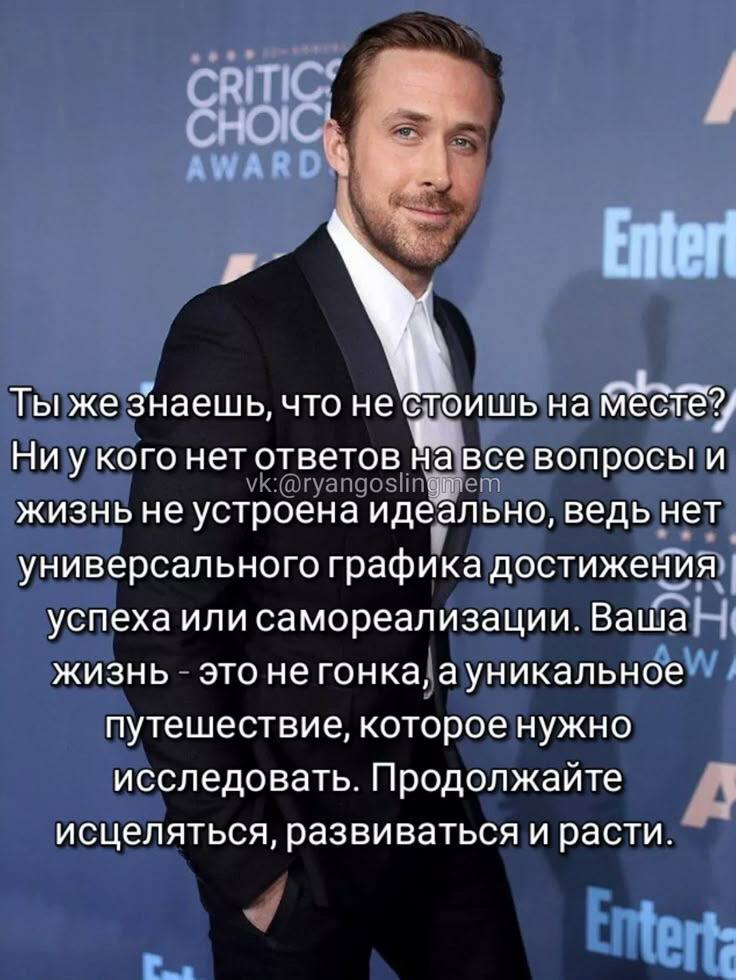

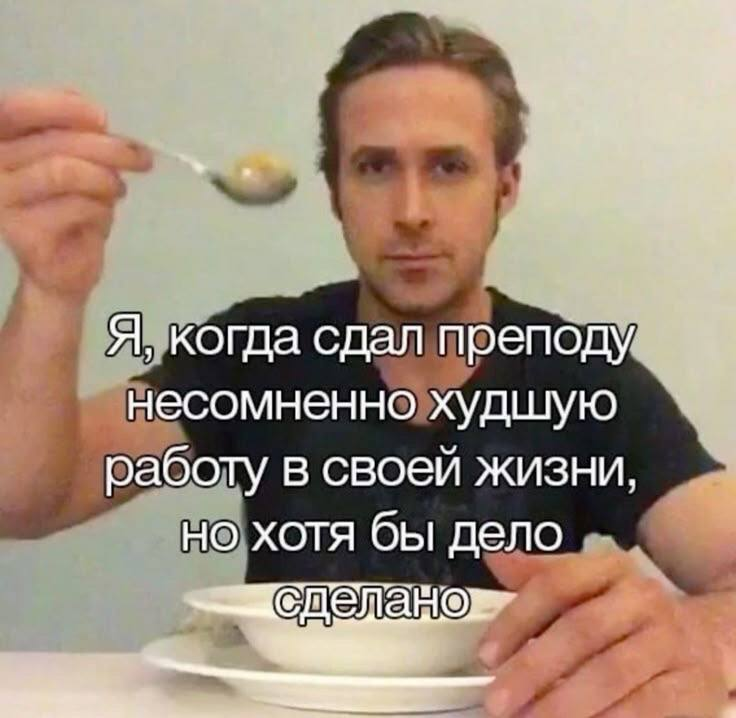

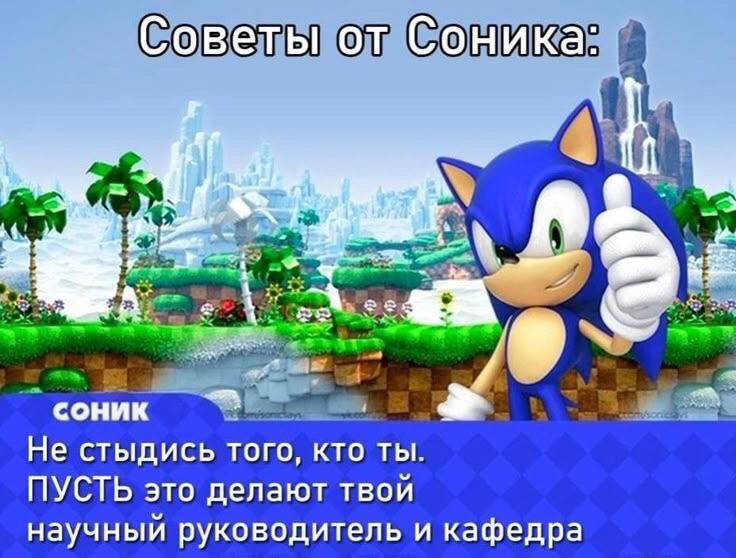